In [2]:
%pip install boto3

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [18]:
from sagemaker import get_execution_role


import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   

from sagemaker import image_uris
from sagemaker.session import s3_input

In [3]:
%pip install s3fs 

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Importando dados de 2017
alu2017 = pd.read_csv('s3://manoelatimossipisi4/alunosCenso2017.csv', sep =';')
escola2017 = pd.read_csv('s3://manoelatimossipisi4/escolasCenso2017.csv', sep = ';')
prest2017 = pd.read_csv('s3://manoelatimossipisi4/prestContas2017.csv', sep =';')
situAlu2017 = pd.read_csv('s3://manoelatimossipisi4/prestContas2017.csv', sep=';')

#Importando dados de 2018
alu2018 = pd.read_csv('s3://manoelatimossipisi4/alunosCenso2018.csv', sep =';')
escola2018 = pd.read_csv('s3://manoelatimossipisi4/escolasCenso2018.csv', sep = ';')
prest2018 = pd.read_csv('s3://manoelatimossipisi4/prestContas2018.csv', sep =',')
situAlu2018 = pd.read_csv('s3://manoelatimossipisi4/prestContas2018.csv', sep=';')

aprov2017 = pd.read_csv('s3://manoelatimossipisi4/tratadoAprovacao2017.csv', sep = ',')
aprov2018 = pd.read_csv('s3://manoelatimossipisi4/tratadoAprovacao2018.csv', sep = ',')

#Gerando tabela com os dados de ambos os anos
tabelao2017 = pd.merge(prest2017, escola2017, left_on="Código da Escola", right_on="CO_ENTIDADE")
tabelao2018 = pd.merge(prest2018, escola2018, left_on="Código da Escola", right_on="CO_ENTIDADE")

/tmp/ipykernel_8199/1147946465.py:6: DtypeWarning: Columns (61,83) have mixed types. Specify dtype option on import or set low_memory=False.
  alu2017 = pd.read_csv('s3://manoelatimossipisi4/alunosCenso2017.csv', sep =';')


Gerando tabela de relação entre modalidades

modens
0    39904
1    28045
Name: Aprovados, dtype: int64

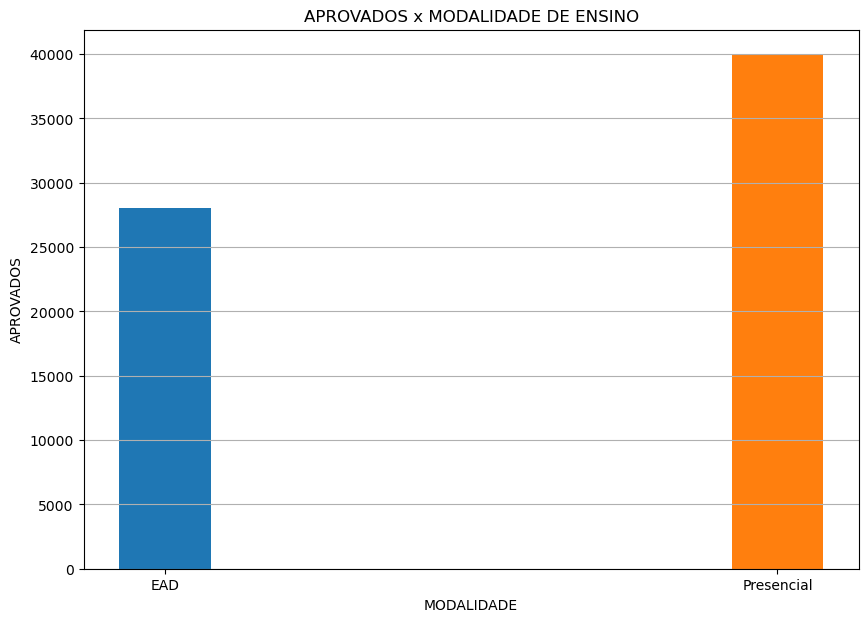

In [ ]:
tabe= aprov2018[['Aprovados', 'modens']].dropna()
aux = tabe.groupby('modens')['Aprovados'].sum()
display(aux)

final= pd.DataFrame(aux)
final= final.transpose()
para= final.iloc[:,1]
atv = final.iloc[:,0]
#criando o gráfico
plt.figure(figsize=(10,7))
para= plt.bar(x='EAD', height= para, width= 0.15)
atv= plt.bar(x= 'Presencial', height=atv , width= 0.15)
plt.xlabel('MODALIDADE')
plt.ylabel('APROVADOS')
plt.title('APROVADOS x MODALIDADE DE ENSINO')
plt.grid(axis='y', linestyle='-')
plt.show()

In [ ]:
media= tabelao2017['Valor Total Previsto'].dropna()
aux= pd.DataFrame(media)
mediaPDDE2017= aux['Valor Total Previsto'].mean()
print('R$ {:.2f}'.format(mediaPDDE2017))

R$ 11492.95


In [ ]:
media2= tabelao2018['Valor Total Previsto'].dropna()
aux2= pd.DataFrame(media2)
mediaPDDE2018= aux2['Valor Total Previsto'].mean()
print('R$ {:.2f}'.format(mediaPDDE2018))

R$ 11371.86


In [6]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn import metrics
aprov2017 = pd.read_csv('s3://manoelatimossipisi4/tratadoAprovacao2017.csv', sep = ',')
aprov2018 = pd.read_csv('s3://manoelatimossipisi4/tratadoAprovacao2018.csv', sep = ',')

aprov2017['TotalAlunos']= aprov2017['Aprovados'] + aprov2017['Reprovados']
aprov2017['isAprovado'] = np.where(aprov2017['Aprovados']/aprov2017['TotalAlunos'] > 0.9, 1, 0)
aprov2017.head()
aprov2018['TotalAlunos']= aprov2018['Aprovados'] + aprov2018['Reprovados']
aprov2018['isAprovado'] = np.where(aprov2018['Aprovados']/aprov2018['TotalAlunos'] > 0.9, 1, 0)
aprov2018.head()

,TotalAlunos,Aprovados,Reprovados,nomeEscola,codEscola,EEX,adimplenciaUEX,bairro,valorTotalPrevisto,cescolrpae,modens,compens,anoCenso,isAprovado
0,748,591,157,ESCOLA MUNICIPAL ANTONIO FARIAS FILHO,26117576,PREF MUN DE RECIFE,Bloqueio CODDE,SAN MARTIN,18440,5,1,1,2018,0
1,668,648,20,ESCOLA MUNICIPAL DOS COELHOS,26118670,PREF MUN DE RECIFE,Bloqueio CODDE,COELHOS,15020,1,0,4,2018,1
2,412,338,74,ESCOLA MUNICIPAL MONTEIRO LOBATO,26118734,PREF MUN DE RECIFE,Adimplente,PEIXINHOS,9320,2,0,4,2018,0
3,188,183,5,ESCOLA MUNICIPAL JULIO VICENTE ALVES DE ARAUJO,26118955,PREF MUN DE RECIFE,Bloqueio CODDE,MORRO DA CONCEICAO,6640,3,0,4,2018,1
4,233,199,34,ESCOLA MUNICIPAL DE DOIS RIOS,26119129,PREF MUN DE RECIFE,Adimplente,COHAB,7060,6,0,4,2018,0


Juntando com a variável de estrutura

In [8]:
censo2017=pd.read_csv('s3://manoelatimossipisi4/escolasCenso2017.csv', sep= ';')
infra2017= censo2017[[ 'CO_ENTIDADE', 'IN_QUADRA_ESPORTES', 'IN_BIBLIOTECA_SALA_LEITURA', 'IN_REFEITORIO', 'IN_INTERNET']]
finalaprov2017= pd.merge(aprov2017,infra2017,left_on='codEscola', right_on='CO_ENTIDADE')
display(finalaprov2017)

censo2018=pd.read_csv('s3://manoelatimossipisi4/escolasCenso2018.csv', sep= ';')
infra2018= censo2018[[ 'CO_ENTIDADE', 'IN_QUADRA_ESPORTES', 'IN_BIBLIOTECA_SALA_LEITURA', 'IN_REFEITORIO', 'IN_INTERNET']]
finalaprov2018= pd.merge(aprov2018,infra2018,left_on='codEscola', right_on='CO_ENTIDADE')
display(finalaprov2018)

,TotalAlunos,Aprovados,Reprovados,nomeEscola,codEscola,EEX,adimplenciaUEX,bairro,valorTotalPrevisto,cescolrpae,modens,compens,anoCenso,isAprovado,CO_ENTIDADE,IN_QUADRA_ESPORTES,IN_BIBLIOTECA_SALA_LEITURA,IN_REFEITORIO,IN_INTERNET
0,668,501,167,ESCOLA MUNICIPAL ANTONIO FARIAS FILHO,26117576,PREF MUN DE RECIFE,Adimplente,SAN MARTIN,18520,5,1,0,2017,0,26117576,1.0,1.0,0.0,1.0
1,667,625,42,ESCOLA MUNICIPAL DOS COELHOS,26118670,PREF MUN DE RECIFE,Adimplente,COELHOS,13000,1,0,4,2017,1,26118670,0.0,1.0,0.0,0.0
2,370,273,97,ESCOLA MUNICIPAL MONTEIRO LOBATO,26118734,PREF MUN DE RECIFE,Adimplente,PEIXINHOS,9680,2,0,4,2017,0,26118734,0.0,1.0,1.0,1.0
3,191,179,12,ESCOLA MUNICIPAL JULIO VICENTE ALVES DE ARAUJO,26118955,PREF MUN DE RECIFE,Adimplente,MORRO DA CONCEICAO,7420,3,0,4,2017,1,26118955,0.0,0.0,1.0,1.0
4,250,203,47,ESCOLA MUNICIPAL DE DOIS RIOS,26119129,PREF MUN DE RECIFE,Adimplente,COHAB,6940,6,0,4,2017,0,26119129,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,141,138,3,ESCOLA MUNICIPAL DONA LUCI SILVA LIMA,26181940,PREF MUN DE RECIFE,Adimplente,IMBIRIBEIRA,3500,6,0,4,2017,1,26181940,0.0,1.0,0.0,1.0
222,147,144,3,ESCOLA MUNICIPAL COMPOSITOR CAPIBA,26212200,PREF MUN DE RECIFE,Adimplente,TORREAO,4700,2,1,0,2017,1,26212200,0.0,1.0,0.0,1.0
223,369,337,32,ESCOLA MUNICIPAL ROZEMAR DE MACEDO LIMA,26212404,PREF MUN DE RECIFE,Adimplente,CASA AMARELA,18140,3,0,4,2017,1,26212404,1.0,1.0,1.0,1.0
224,134,133,1,ESCOLA MUNICIPAL MILTON ALMEIDA DOS SANTOS,26419726,PREF MUN DE RECIFE,Adimplente,IMBIRIBEIRA,3980,6,0,4,2017,1,26419726,0.0,1.0,1.0,1.0


,TotalAlunos,Aprovados,Reprovados,nomeEscola,codEscola,EEX,adimplenciaUEX,bairro,valorTotalPrevisto,cescolrpae,modens,compens,anoCenso,isAprovado,CO_ENTIDADE,IN_QUADRA_ESPORTES,IN_BIBLIOTECA_SALA_LEITURA,IN_REFEITORIO,IN_INTERNET
0,748,591,157,ESCOLA MUNICIPAL ANTONIO FARIAS FILHO,26117576,PREF MUN DE RECIFE,Bloqueio CODDE,SAN MARTIN,18440,5,1,1,2018,0,26117576,1.0,1.0,0.0,1.0
1,668,648,20,ESCOLA MUNICIPAL DOS COELHOS,26118670,PREF MUN DE RECIFE,Bloqueio CODDE,COELHOS,15020,1,0,4,2018,1,26118670,0.0,1.0,0.0,0.0
2,412,338,74,ESCOLA MUNICIPAL MONTEIRO LOBATO,26118734,PREF MUN DE RECIFE,Adimplente,PEIXINHOS,9320,2,0,4,2018,0,26118734,0.0,1.0,1.0,1.0
3,188,183,5,ESCOLA MUNICIPAL JULIO VICENTE ALVES DE ARAUJO,26118955,PREF MUN DE RECIFE,Bloqueio CODDE,MORRO DA CONCEICAO,6640,3,0,4,2018,1,26118955,0.0,1.0,1.0,1.0
4,233,199,34,ESCOLA MUNICIPAL DE DOIS RIOS,26119129,PREF MUN DE RECIFE,Adimplente,COHAB,7060,6,0,4,2018,0,26119129,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,153,151,2,ESCOLA MUNICIPAL COMPOSITOR CAPIBA,26212200,PREF MUN DE RECIFE,Adimplente,TORREAO,4640,2,1,0,2018,1,26212200,0.0,1.0,0.0,1.0
224,394,357,37,ESCOLA MUNICIPAL ROZEMAR DE MACEDO LIMA,26212404,PREF MUN DE RECIFE,Bloqueio CODDE,CASA AMARELA,16640,3,0,4,2018,1,26212404,1.0,1.0,1.0,1.0
225,146,143,3,ESCOLA MUNICIPAL MILTON ALMEIDA DOS SANTOS,26419726,PREF MUN DE RECIFE,Adimplente,IMBIRIBEIRA,3660,6,0,4,2018,1,26419726,0.0,1.0,1.0,1.0
226,112,108,4,ESCOLA MUNICIPAL CHICO SCIENCE,26419734,PREF MUN DE RECIFE,Adimplente,VASCO DA GAMA,3000,3,0,4,2018,1,26419734,0.0,0.0,0.0,1.0


Legendando os bairros para que possamos utilizar ele no Algoritmo

In [ ]:
trocar = {
    'COHAB' : 1,
    'IBURA' : 2,
    'VARZEA': 3,
    'IMBIRIBEIRA': 4,
    'JORDAO': 5,
    'SANTO AMARO': 6,
    'NOVA DESCOBERTA': 7,
    'IPUTINGA': 8,
    'AGUA FRIA': 9,
    'BOA VIAGEM': 10,
    'VASCO DA GAMA': 11,
    'MACAXEIRA': 12,
    'SAN MARTIN': 13,
    'PASSARINHO': 14,
    'TORROES': 15,
    'PINA': 16,
    'AREIAS': 17,
    'CASA AMARELA': 18,
    'BEBERIBE': 19,
    'CAMPO GRANDE': 20,
    'LINHA DO TIRO': 21,
    'PRADO': 22,
    'IPSEP': 23,
    'FUNDAO': 24,
    'ILHA JOANA BEZERRA': 25,
    'AFOGADOS': 26,
    'TORRE': 27,
    'ALTO JOSE BONIFACIO': 28,
    'DOIS UNIDOS': 29,
    'BARRO': 30,
    'ENCRUZILHADA': 31,
    'CORREGO DO JENIPAPO': 32,
    'COQUEIRAL': 33,
    'CORDEIRO': 34,
    'ENGENHO DO MEIO': 35,
    'BREJO DA GUABIRABA': 36,
    'ALTO SANTA TEREZINHA': 37,
    'ESTANCIA': 38,
    'SANCHO': 39,
    'CAMPINA DO BARRETO': 40,
    'MUSTARDINHA': 41,
    'TEJIPIO': 42,
    'ILHA DO LEITE': 43,
    'DERBY': 44,
    'ILHA DO RETIRO': 45,
    'MADALENA': 46,
    'MANGABEIRA': 47,
    'CAXANGA': 48,
    'PEIXINHOS': 49,
    'CAJUEIRO': 50,
    'ESPINHEIRO': 51,
    'TORREAO': 52,
    'TAMARINEIRA': 53,
    'COELHOS': 54,
    'BOA VISTA': 55,
    'GUABIRABA': 56,
    'RECIFE': 57,
    'MORRO DA CONCEICAO': 58,
    'JAQUEIRA': 59,
    'ALTO JOSE DO PINHO': 60,
    'ARRUDA': 61,
    'BRASILIA TEIMOSA': 62,
    'DOIS IRMAOS': 63,
    'BREJO DE BEBERIBE ': 64
}
finalaprov2017['bairro_legenda'] = finalaprov2017['bairro'].map(trocar)
finalaprov2018['bairro_legenda'] = finalaprov2018['bairro'].map(trocar)
finalaprov2017.head()

,TotalAlunos,Aprovados,Reprovados,nomeEscola,codEscola,EEX,adimplenciaUEX,bairro,valorTotalPrevisto,cescolrpae,modens,compens,anoCenso,isAprovado,CO_ENTIDADE,IN_QUADRA_ESPORTES,IN_BIBLIOTECA_SALA_LEITURA,IN_REFEITORIO,IN_INTERNET,bairro_legenda
0,668,501,167,ESCOLA MUNICIPAL ANTONIO FARIAS FILHO,26117576,PREF MUN DE RECIFE,Adimplente,SAN MARTIN,18520,5,1,0,2017,0,26117576,1.0,1.0,0.0,1.0,13.0
1,667,625,42,ESCOLA MUNICIPAL DOS COELHOS,26118670,PREF MUN DE RECIFE,Adimplente,COELHOS,13000,1,0,4,2017,1,26118670,0.0,1.0,0.0,0.0,54.0
2,370,273,97,ESCOLA MUNICIPAL MONTEIRO LOBATO,26118734,PREF MUN DE RECIFE,Adimplente,PEIXINHOS,9680,2,0,4,2017,0,26118734,0.0,1.0,1.0,1.0,49.0
3,191,179,12,ESCOLA MUNICIPAL JULIO VICENTE ALVES DE ARAUJO,26118955,PREF MUN DE RECIFE,Adimplente,MORRO DA CONCEICAO,7420,3,0,4,2017,1,26118955,0.0,0.0,1.0,1.0,58.0
4,250,203,47,ESCOLA MUNICIPAL DE DOIS RIOS,26119129,PREF MUN DE RECIFE,Adimplente,COHAB,6940,6,0,4,2017,0,26119129,0.0,1.0,1.0,1.0,1.0


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## 2017
x2017 = finalaprov2017[["valorTotalPrevisto","IN_QUADRA_ESPORTES","IN_BIBLIOTECA_SALA_LEITURA","IN_REFEITORIO","IN_INTERNET"]]
y2017 = finalaprov2017["isAprovado"]

SEED = 25
np.random.seed(SEED)
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x2017, y2017, test_size = 0.3,
                                                         stratify = y2017)

modelo2017 = DecisionTreeClassifier()
modelo2017.fit(raw_treino_x, treino_y)
previsoes2017 = modelo2017.predict(raw_teste_x)

acuracia2017 = accuracy_score(teste_y, previsoes2017) * 100
acuracia2017 = round(acuracia2017,2)
print("A acurácia de 2017 foi",acuracia2017,"%")

# 2018
x2018 = finalaprov2018[["valorTotalPrevisto","IN_QUADRA_ESPORTES","IN_BIBLIOTECA_SALA_LEITURA","IN_REFEITORIO","IN_INTERNET"]]
y2018 = finalaprov2018["isAprovado"]

SEED = 25
np.random.seed(SEED)
raw_treino_x_2018, raw_teste_x_2018, treino_y_2018, teste_y_2018 = train_test_split(x2018, y2018, test_size = 0.3,
                                                         stratify = y2018)

modelo = DecisionTreeClassifier()
modelo.fit(raw_treino_x_2018, treino_y_2018)
previsoes = modelo.predict(raw_teste_x_2018)

acuracia2018 = accuracy_score(teste_y_2018, previsoes) * 100
print("A acurácia de 2018 foi %.2f%%" % acuracia2018)

A acurácia de 2017 foi 73.53 %
A acurácia de 2018 foi 56.52%


In [ ]:

from sklearn.dummy import DummyClassifier
dummy_stratified = DummyClassifier(strategy='most_frequent')
dummy_stratified.fit(raw_treino_x, treino_y)
dummy = dummy_stratified.score(raw_teste_x, teste_y) * 100
print("Dummy: %.2f%%" % dummy)


Dummy: 52.94%


In [ ]:
escolaModelo = [12000,1,0,1,0]
previsaoEscolaModelo = modelo2017.predict([escolaModelo])
previsaoEscolaModelo = str(previsaoEscolaModelo)
#0 NÃO TERÁ MAIORIA APROVADA
#1 TERÁ MAIORIA APROVADA
if previsaoEscolaModelo == '[1]':
    print("A maioria dos alunos serão aprovados")
else:   
    print("A maioria dos alunos serão reprovados")

A maioria dos alunos serão aprovados


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [16]:
boto3.Session().resource('s3').Bucket('manoelatimossipisi4').Object(os.path.join('sagemaker', 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format('manoelatimossipisi4', 'sagemaker'), content_type='csv')
sagemaker.image_uris.retrieve("xgboost", "ap-northeast-1",version='1.5-1')

'354813040037.dkr.ecr.ap-northeast-1.amazonaws.com/sagemaker-xgboost:1.5-1'

In [19]:
container = image_uris.retrieve('xgboost', boto3.Session().region_name, '1')

In [20]:
sess = sagemaker.Session()

In [20]:
sess = sagemaker.Session()

In [21]:
cont = sagemaker.estimator.Estimator(image_uri=container,role=sagemaker.get_execution_role(), instance_count=1, instance_type='ml.m5.large',output_path='s3://{}/{}/output'.format('manoelatimossipisi4','sagemaker' ),sagemaker_session=sess)

In [22]:
cont.set_hyperparameters(bjective='binary:logistic', eval_metric='error', verbosity=0, n_estimators = 500, max_depth = 6, learning_rate = 0.3, colsample_bytree = 0.5,num_round=100)

In [26]:
cont.fit({'train': s3_input_train})
trainedmodel = sagemaker.model.Model(
    model_data='s3://manoelatimossipisi4/sagemaker/output/xgboost-2023-04-06-00-04-06-060/output/model.tar.gz',
    image_uri=container,
    role='LabRole')  
predictor = trainedmodel.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

INFO:sagemaker:Creating training-job with name: xgboost-2023-04-06-00-09-31-355


2023-04-06 00:09:31 Starting - Starting the training job...
2023-04-06 00:09:49 Starting - Preparing the instances for training......
2023-04-06 00:10:42 Downloading - Downloading input data...
2023-04-06 00:11:27 Training - Downloading the training image...
2023-04-06 00:12:03 Training - Training image download completed. Training in progress...Arguments: train
[2023-04-06:00:12:10:INFO] Running standalone xgboost training.
[2023-04-06:00:12:10:INFO] Path /opt/ml/input/data/validation does not exist!
[2023-04-06:00:12:10:INFO] File size need to be processed in the node: 0.0mb. Available memory size in the node: 326.11mb
[2023-04-06:00:12:10:INFO] Determined delimiter of CSV input is ','
[00:12:10] S3DistributionType set as FullyReplicated
[00:12:10] 159x4 matrix with 636 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[00:12:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]#011train-error:-951

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Training seconds: 107
Billable seconds: 107


INFO:sagemaker:Creating model with name: xgboost-2023-04-06-00-12-46-454
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-04-06-00-12-47-199
INFO:sagemaker:Creating endpoint with name xgboost-2023-04-06-00-12-47-199


-------!